# Q-Learning for FrozenLake 4x4

Based on https://colab.research.google.com/drive/1oqon14Iq8jzx6PhMJvja-mktFTru5GPl#scrollTo=5aQKQMJTJBPH

<!-- ![image.png](attachment:image.png) -->

The Frozen Lake environment specifications can be found [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

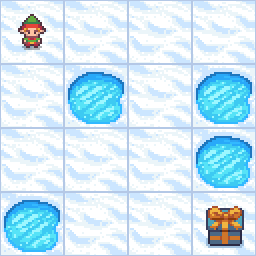

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake.

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.

The player makes moves until they reach the goal or fall in a hole.

## Imports

We start by importing the dependencies: Gymnasium (and Wrappers), numpy, random and matplotlib.

In [1]:
import gymnasium as gym
from gymnasium import RewardWrapper

import numpy as np
import random
import matplotlib.pyplot as plt


## Setting up and exploring the environment

Even though the original problem description has a slippery environment, we are going to start working in a non-slippery environment. In it, if you go right, you only go right; in the original environment, if you intend to go right, you can go right, up or down with 1/3 probability.

To make a deterministic Frozen Lake environment, we make use of the `is_slippery` flag. We'll also use `ansi`as rendering mode, as it is faster to visualize (the other option is `human`, which provides a graphical visualization).

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")

Render the environment on the screen.

In [3]:
env.reset()
print(env.render())



SFFF
FHFH
FFFH
HFFG



## Setting up custom environment

The default environment has this reward schedule:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

In an effort to make it more realistic, we decided to apply a RewardWrapper and the reward schedule of the altered environment is:

- Reach goal: +2
- Reach hole: -1
- Reach frozen: -0.01


In [4]:
class CustomRewardWrapper(RewardWrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
        # Define your custom rewards for each square
        self.custom_rewards = {
            b'S': 0.0,  # Start
            b'F': -0.01,  # Frozen
            b'H': -1,  # Hole
            b'G': 2    # Goal
        }

    def step(self, action):
        # Take a step in the environment
        step_result = self.env.step(action)
        #print("action " + str(action))
        # Unpack the step result with the additional 'prob' dictionary
        new_state, reward, terminated, truncated, info = step_result
        
        # Customize the reward based on the current state
        current_state = self.env.unwrapped.s
        row = current_state // self.ncol
        col = current_state - row * self.ncol
        tile_type = self.desc[row, col]
        
        new_reward = self.custom_rewards.get(tile_type, reward)
        #print(f"Current state: {tile_type} {new_state}, new reward: {new_reward}")
        
        return new_state, new_reward, terminated, truncated, info

## Q-Learning

We now proceed to implementing Q-learning and aplying it to our environment. In Q-learning, q-values are updated based on:

$Q(S_{t},A_{t}) \leftarrow Q(S_{t},A_{t}) + \alpha [R_{t+1} + \gamma \max_{a} Q(S_{t+1},a) - Q(S_{t},A_{t})]$

where $\alpha$ is the learning rate (aka step size), and $\gamma$ is the discount factor.

### The Q-table

First, we create a Q-table of shape *state_size* x *action_size*, and initialize its values with zeros.
<br>
**QLearn Class →** *self.qtable = np.zeros((self.state_size, self.action_size))*

### Learning hyperparameters

The Q-learning algorithm has the following hyperparameters:
- the total number of episodes to run
- the maximum number of steps per episode
- the learning rate
- the discount factor
- the range for the exploration parameter epsilon
- the epsilon decay rate

The class QLearn Implements Q-learning and uses it to train the agent, using an $\epsilon$-greedy action selection with decreasing exploration probability. Prints some information as learning takes place.
Keeps a list of the total rewards obtained after each episode.

In [5]:
class QLearn:
    
    def __init__(self,env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,rows):
        self.env = env
        self.action_size = env.action_space.n
        self.state_size = env.observation_space.n
        self.qtable = np.zeros((self.state_size, self.action_size))
        self.rewards = []
        self.total_episodes = total_episodes      # Total episodes
        self.max_steps = max_steps                # Max steps per episode
        self.learning_rate = learning_rate        # Learning rate
        self.gamma = gamma                        # Discounting factor
        self.epsilon = epsilon                    # Exploration rate
        self.max_epsilon = max_epsilon            # Exploration probability at start
        self.min_epsilon = min_epsilon            # Minimum exploration probability
        self.decay_rate = decay_rate              # Exponential decay rate for exploration prob
        self.rows = rows                          # Size of the board


    
    def q_learning(self):

        # Iterate through the number of episodes
        for episode in range(self.total_episodes):
            #print(f"episode: {episode}")
            
            # Reset the environment
            state = self.env.reset()[0]
            
            #print(f"state: {state}")
            episode_reward = 0
            
            for _ in range(self.max_steps):
                # Choose an action (a) in the current world state (s)
                
                # Shall we explore or exploit?
                ## generate a random number
                exp_exp_tradeoff = random.uniform(0, 1)
                
                ## If this number > epsilon --> exploitation 
                if exp_exp_tradeoff > self.epsilon:
                    # taking the biggest Q value for this state
                    # your code here
                    #---
                    action = np.argmax(self.qtable[state,:])
                    #---
                # Else explore randomly
                else:
                    # your code here
                    #---
                    action = self.env.action_space.sample()
                    #---
                    
                # Take the action (a) and observe the outcome state (s') and reward (r)
                new_state, reward, terminated, truncated, info = self.env.step(action)
                
                # Update Q(s,a) = Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                # your code here
                #---
                self.qtable[state, action] = self.qtable[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.qtable[new_state, :]) - self.qtable[state, action])
                #---
                
                episode_reward += reward
                
                # Update state
                state = new_state
                
                # If done, finish episode
                if terminated or truncated:
                    break
            
            # reduce epsilon (because we need less and less exploration)
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*episode)
            
            self.rewards.append(episode_reward)

    def plot_rewards(self):
        cumulative_sum = np.cumsum(self.rewards)
        plt.plot(cumulative_sum)
        plt.show()
    
    def plot_qtable(self):
        
        # Set the size of the figure
        fig, ax = plt.subplots(figsize=(30, 30))

        # Plot the self.qtable using imshow with equal aspect ratio
        im = ax.imshow(self.qtable, cmap='viridis', interpolation='nearest', aspect='equal')

        # Add text annotations for each cell
        for i in range(self.qtable.shape[0]):
            for j in range(self.qtable.shape[1]):
                ax.text(j, i, f'{self.qtable[i, j]:.2f}', ha='center', va='center', color='w')

        # Add a colorbar to show the scale
        plt.colorbar(im, ax=ax)
        ax.axis('off')
        plt.xlabel("Episodes")
        plt.ylabel("Cummulative Reward")

        # Display the plot
        plt.show()
        
    def print_optimal(self):
        # Print the best action in every state
        #LEFT = 0 DOWN = 1 RIGHT = 2 UP = 3
        print(np.argmax(self.qtable,axis=1).reshape(self.rows,self.rows))
        
    def greedy_policy(self):
        state = self.env.reset()[0]

        n_steps = 0
        terminated = False
        while terminated == False and n_steps < self.max_steps:
            print(self.env.render())
            # Take the action (index) that has the maximum expected future reward given the state
            # your code here
            #---
            action = np.argmax(self.qtable[state,:])
            #---

            # Make a step to the next state
            # your code here
            #---
            new_state, reward, terminated, truncated, info = self.env.step(action)
            state = new_state
            #---
            
            n_steps += 1
        
        print(self.env.render())
        self.env.close()
        print(n_steps)

       

## Comparing the environments

### 4x4 not slippery:

- **Hyperparameters:**


In [6]:
total_episodes = 1000         # Total episodes
max_steps = 100               # Max steps per episode

learning_rate = 0.8           # Learning rate
gamma = 0.95                  # Discounting factor

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob

- **Default:**

In [7]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")
env.reset()
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



Run the Q-learning alghorithm.

In [8]:
Default = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,4)
Default.q_learning()

Plot of the cummulative reward obtained throughout the episodes.

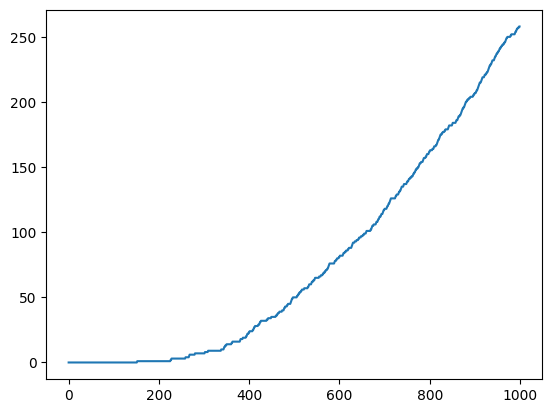

In [9]:
Default.plot_rewards()

Plot of the resulting Q-table.

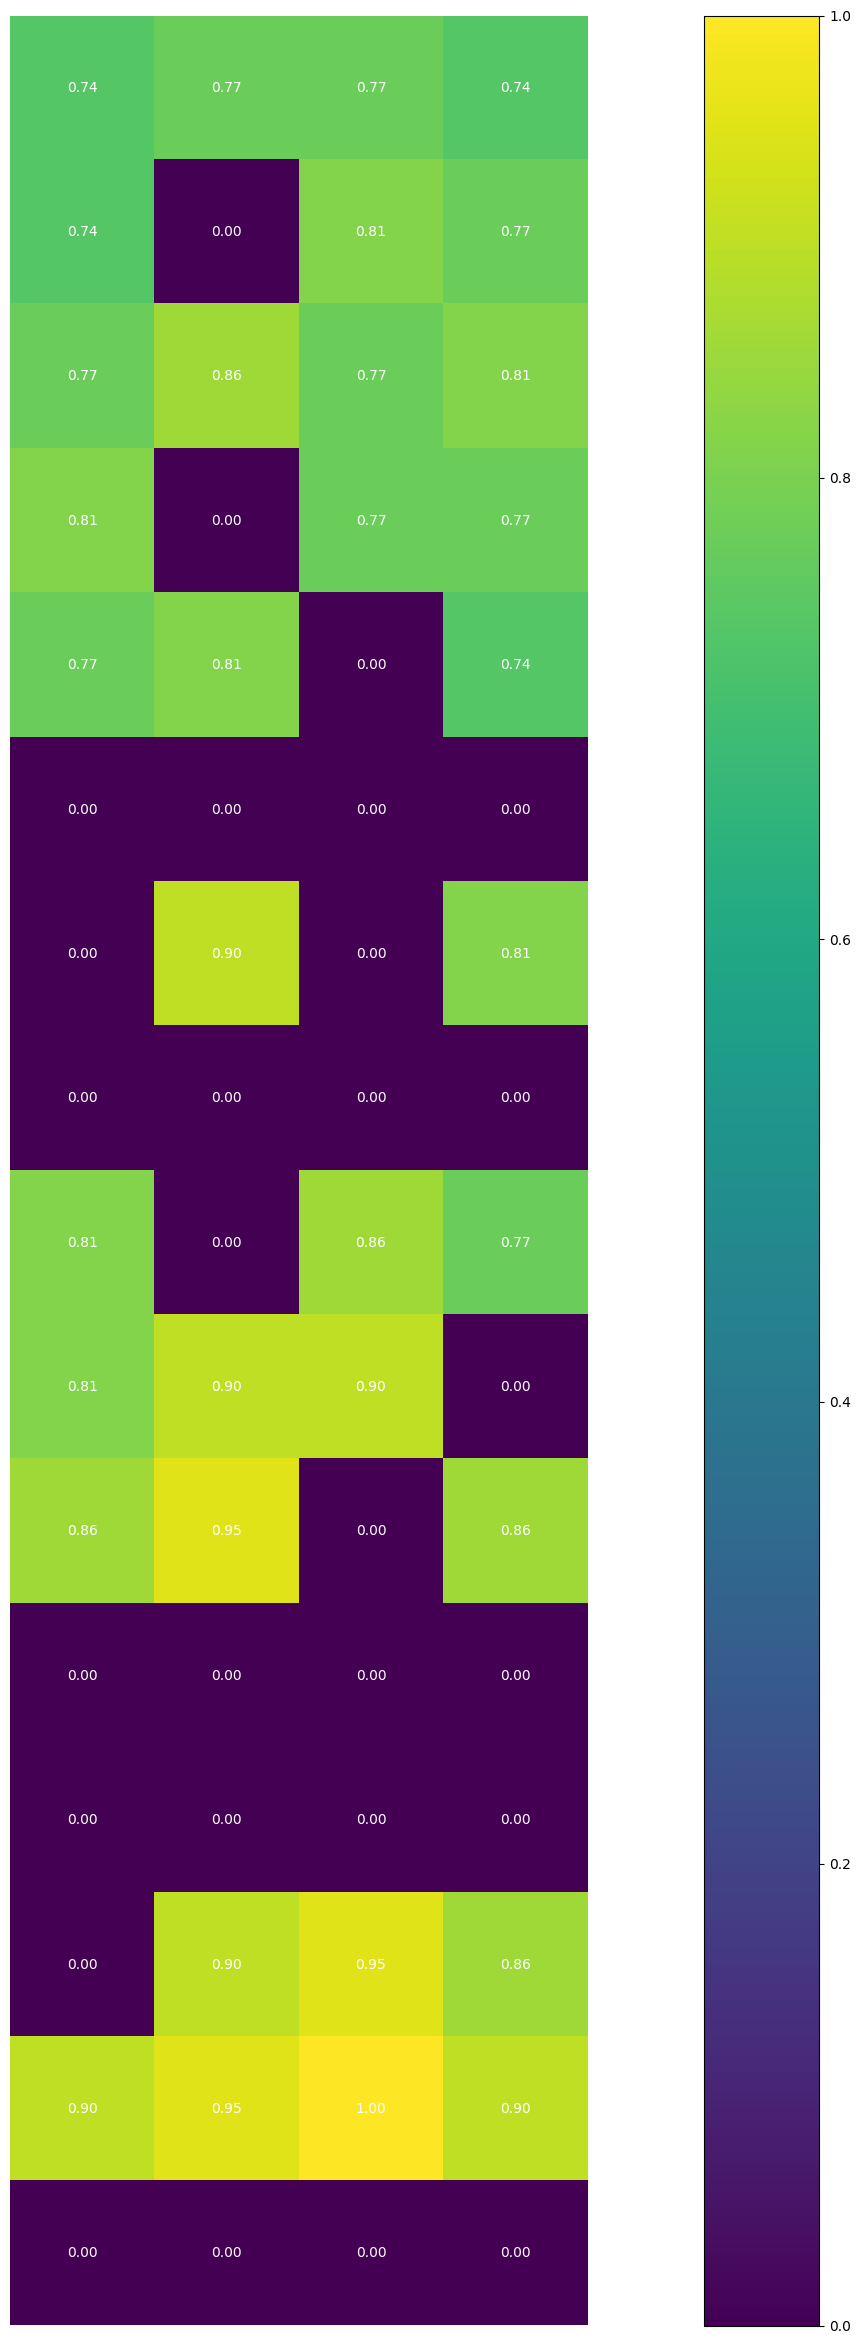

In [10]:
Default.plot_qtable()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [11]:
Default.print_optimal()

[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [12]:
Default.greedy_policy()


SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

6


- **Custom:**

In [13]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")
env = CustomRewardWrapper(env)
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



Run the Q-learning alghorithm.

In [14]:
Custom = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,4)
Custom.q_learning()

/home/pinthoz/.pyenv/versions/TP2/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.ncol to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ncol` for environment variables or `env.get_wrapper_attr('ncol')` that will search the reminding wrappers.
  logger.warn(
/home/pinthoz/.pyenv/versions/TP2/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


Plot of the cummulative reward obtained throughout the episodes.

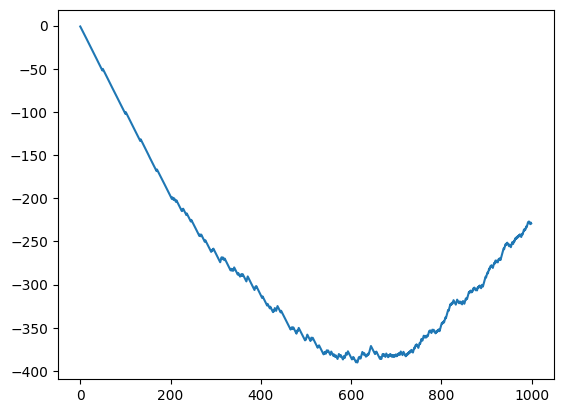

In [29]:
Custom.plot_rewards()

Plot of the resulting Q-table.

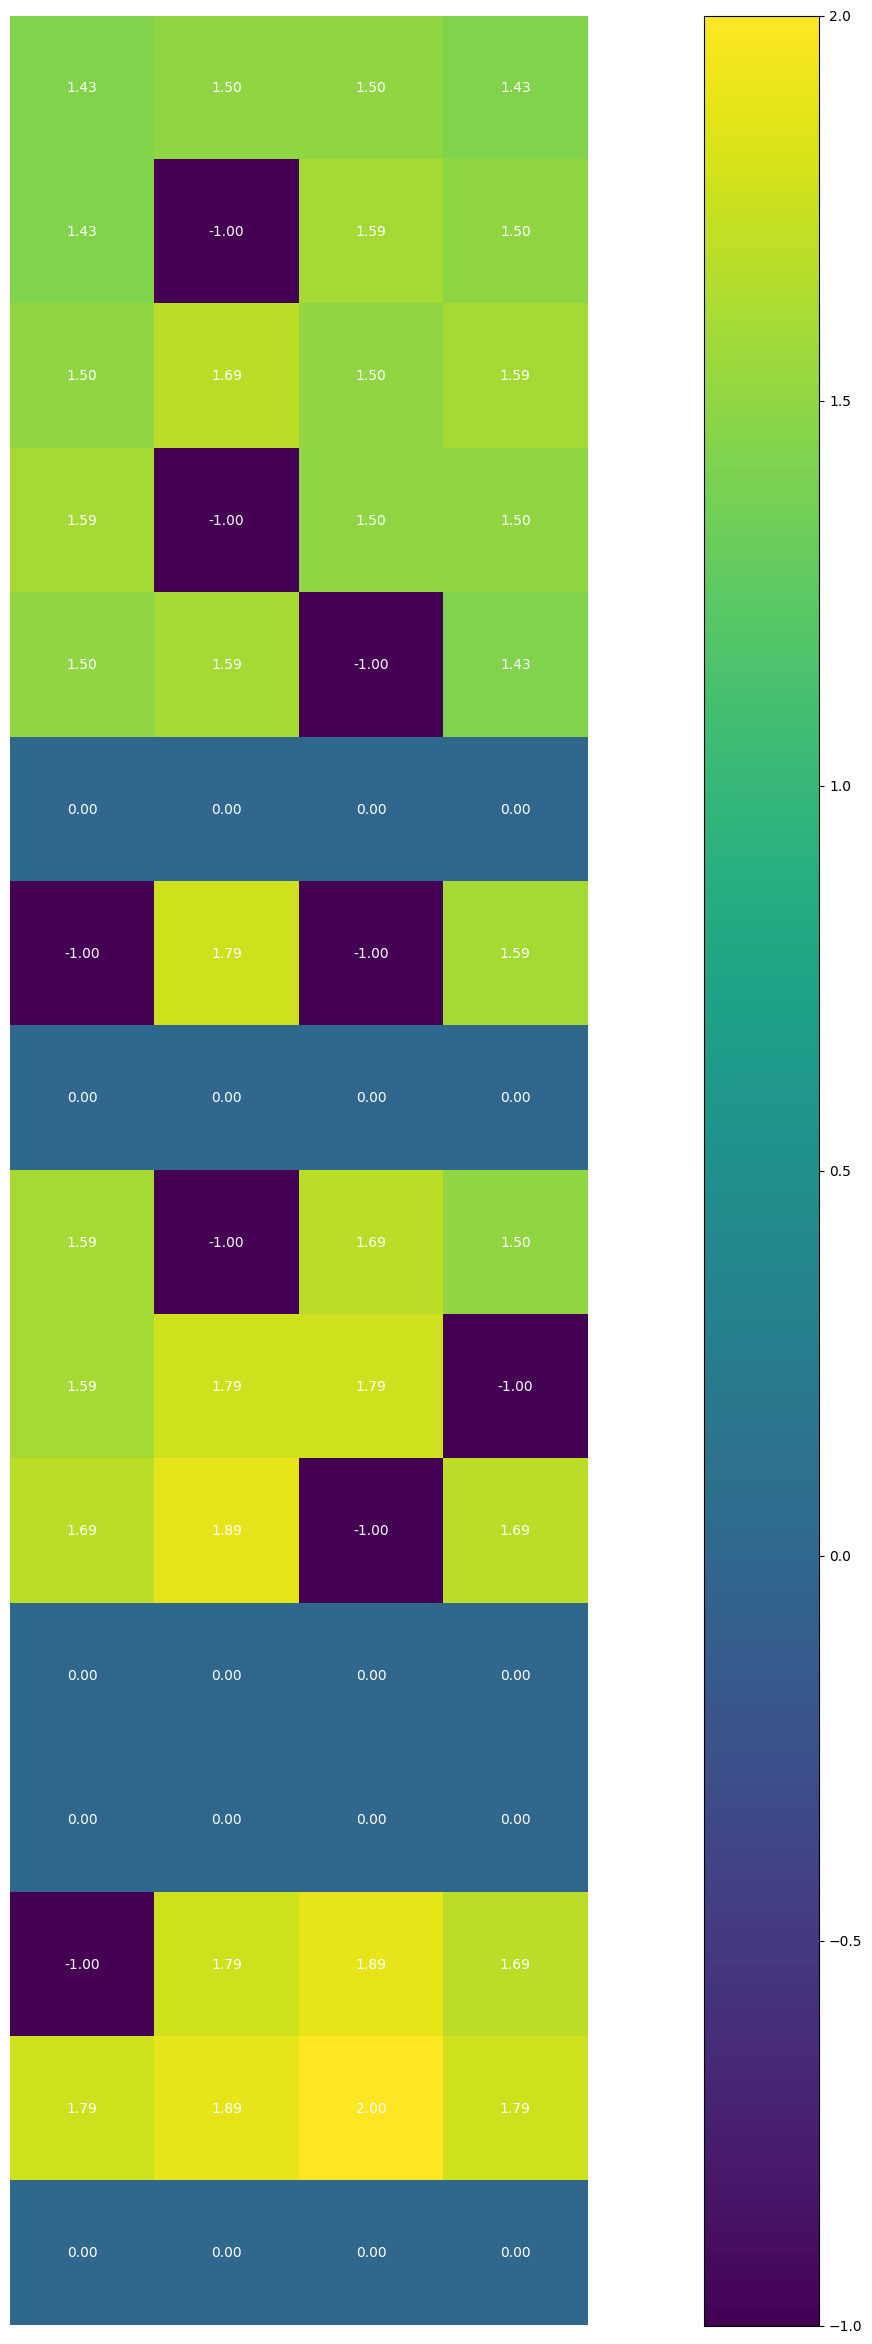

In [16]:
Custom.plot_qtable()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [17]:
Custom.print_optimal()

[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [18]:
Custom.greedy_policy()


SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

6


- Both find the optimal solution (6 steps).

### 8x8 not slippery:

- **Hyperparameters:**

In [26]:
total_episodes = 2000000         # Total episodes
max_steps = 100               # Max steps per episode

learning_rate = 0.8           # Learning rate
gamma = 0.95                  # Discounting factor

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob

- **Default:**

In [27]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="ansi")
env.reset()
print(env.render())


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



Run the Q-learning alghorithm

In [37]:
Default = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,8)
Default.q_learning()

KeyboardInterrupt: 

Plot of the cummulative reward obtained throughout the episodes.

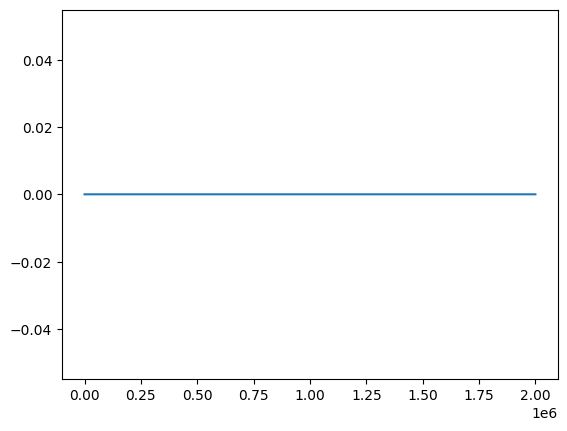

In [30]:
Default.plot_rewards()

Plot of the resulting Q-table.

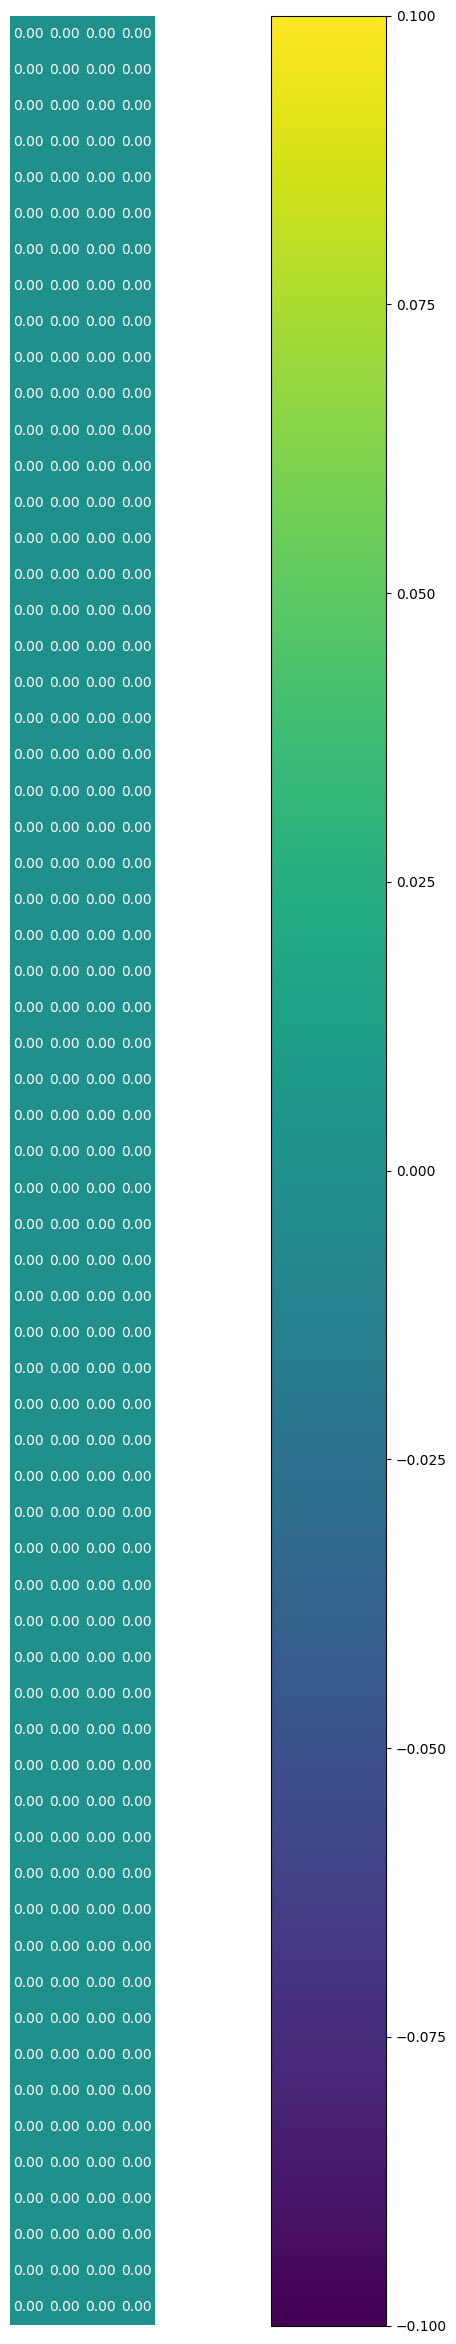

In [23]:
Default.plot_qtable()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [31]:
Default.print_optimal()

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [32]:
Default.greedy_policy()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Left)
SFFFFFFF
FFFFFF

- **Custom:**

In [39]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="ansi")
env = CustomRewardWrapper(env)
env.reset()
print(env.render())


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [40]:
Custom = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,8)
Custom.q_learning()

Plot of the cummulative reward obtained throughout the episodes.


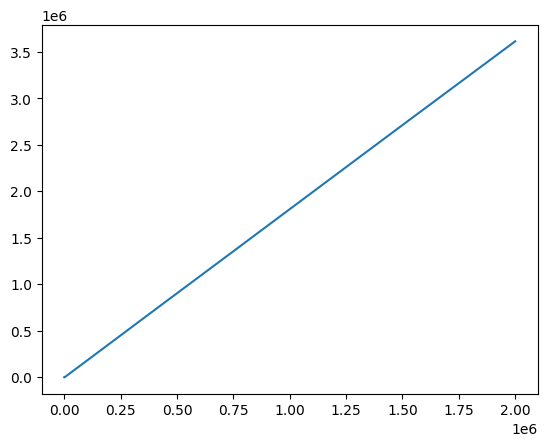

In [41]:
Custom.plot_rewards()

Plot of the resulting Q-table.

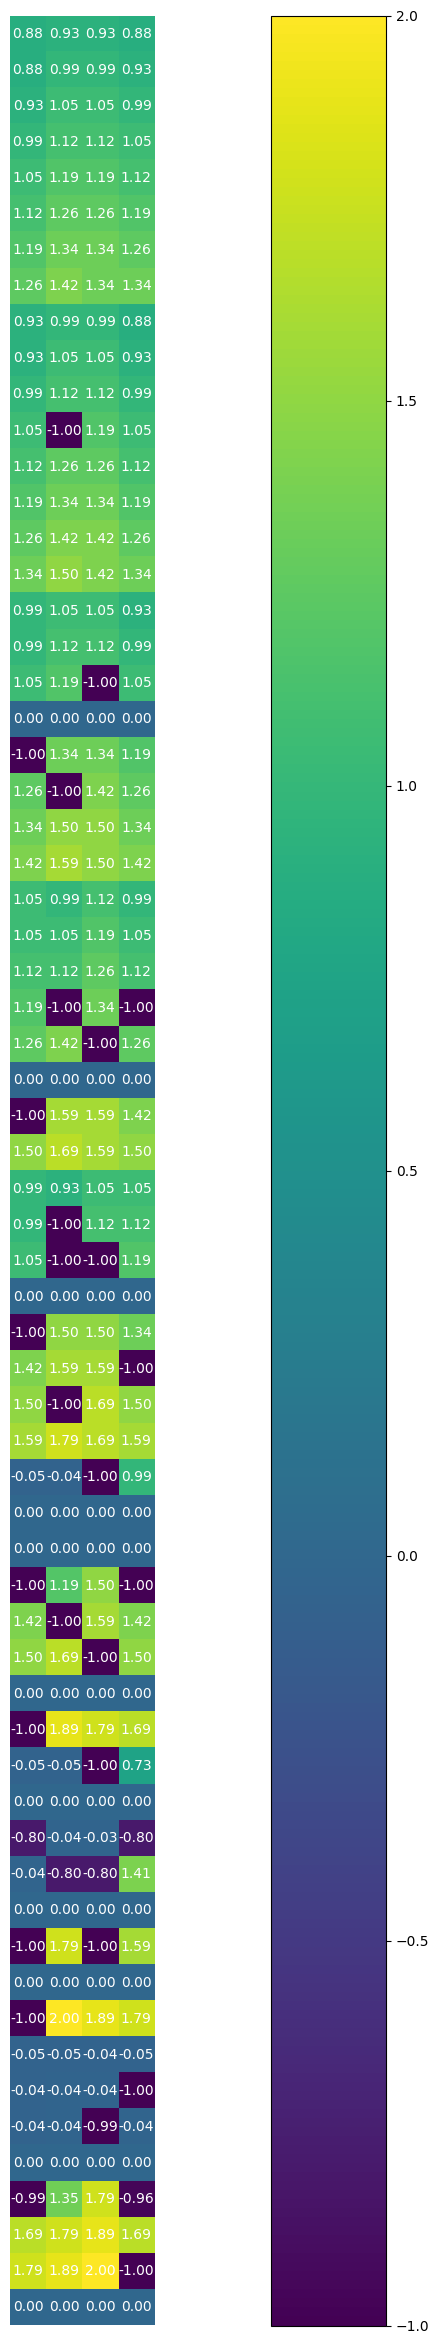

In [42]:
Custom.plot_qtable()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [43]:
Custom.print_optimal()

[[1 1 1 1 1 2 1 1]
 [1 1 1 2 1 1 1 1]
 [1 1 1 0 2 2 1 1]
 [2 2 2 2 1 0 1 1]
 [3 3 3 0 1 1 2 1]
 [3 0 0 2 2 1 0 1]
 [3 0 2 3 0 1 0 1]
 [2 2 3 0 2 2 2 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [44]:
Custom.greedy_policy()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

  (Down)
SFFFFFFF
F